In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature
from cs231n.features import extract_features

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

In [4]:
num_color_bins = 10
hog = lambda x: hog_feature(x)
hsv = lambda x: color_histogram_hsv(x, nbin=num_color_bins)
fns = [hog, hsv]

X_train_feats = extract_features(X_train, fns)
X_val_feats = extract_features(X_val, fns)
X_test_feats = extract_features(X_test, fns)

mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

In [5]:
from cs231n.classifiers.linear_classifier import LinearSVM

In [6]:
learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=False)
        
        y_pred = svm.predict(X_train_feats)
        train_accuracy = np.mean(y_pred == y_train)   
        
        y_pred = svm.predict(X_val_feats)
        val_accuracy = np.mean(y_pred == y_val)
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm

for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.100510 val accuracy: 0.113000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.101959 val accuracy: 0.120000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.414347 val accuracy: 0.418000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.094490 val accuracy: 0.087000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.413184 val accuracy: 0.424000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.403796 val accuracy: 0.402000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.413265 val accuracy: 0.402000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.408898 val accuracy: 0.403000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.324204 val accuracy: 0.300000
best validation accuracy achieved during cross-validation: 0.424000


In [7]:
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.422


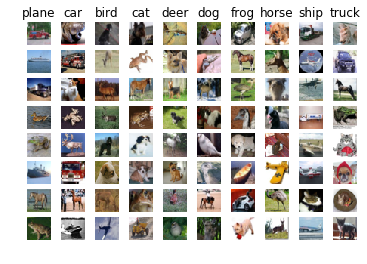

In [8]:
examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for idx, cls in enumerate(classes):
    idxs = np.where((y_test != idx) & (y_test_pred == idx))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, index in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + idx + 1)
        plt.imshow(X_test[index].astype(np.uint8))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [9]:
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [10]:
from cs231n.classifiers.neural_net import TwoLayerNet

In [15]:
input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

max_cnt = 100
best_val = 0.0
for cnt in range(max_cnt):
    lr = 10 ** np.random.uniform(-3, 0)
    reg = 10 ** np.random.uniform(-5, 5)
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                     learning_rate=lr, reg=0.0, num_iters=100)
    val_acc = np.mean(net.predict(X_val_feats) == y_val)
    if val_acc > best_val:
        best_net = net
        best_val = val_acc
print('val acc is: %0.1f %%' %(best_val * 100))    

iteration 0 / 100: loss 2.302585
iteration 0 / 100: loss 2.302522
iteration 0 / 100: loss 2.302316
iteration 0 / 100: loss 2.302323
iteration 0 / 100: loss 1.853505
iteration 0 / 100: loss 1.676730
iteration 0 / 100: loss 1.609285
iteration 0 / 100: loss 1.384059
iteration 0 / 100: loss 1.297580
iteration 0 / 100: loss 1.280783
iteration 0 / 100: loss 1.319774
iteration 0 / 100: loss 1.392213
iteration 0 / 100: loss 1.352003
iteration 0 / 100: loss 1.206368
iteration 0 / 100: loss 1.192687
iteration 0 / 100: loss 1.208403
iteration 0 / 100: loss 1.154563
iteration 0 / 100: loss 1.115568
iteration 0 / 100: loss 1.225101
iteration 0 / 100: loss 1.284121
iteration 0 / 100: loss 1.113822
iteration 0 / 100: loss 1.258926
iteration 0 / 100: loss 1.215966
iteration 0 / 100: loss 1.215403
iteration 0 / 100: loss 1.040473
iteration 0 / 100: loss 1.030733
iteration 0 / 100: loss 0.930572
iteration 0 / 100: loss 0.936598
iteration 0 / 100: loss 0.846672
iteration 0 / 100: loss 0.933043
iteration 

In [16]:
test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.533
